In [159]:
%matplotlib inline
#%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt

import time
import csv
import h5py
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers, initializers, constraints
from keras.optimizers import RMSprop, Adam
from keras.engine import InputSpec, Layer
np.random.seed(1234)
from keras.utils import plot_model
import keras.backend.tensorflow_backend as Kback
from IPython.display import clear_output
import keras as K
import tensorflow as tf
import scipy.io as sio
from scipy import stats
import scipy as scp
from scipy.signal import resample
import keras
from keras.backend.tensorflow_backend import set_session
import os
import random
import time
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=1
set_session(tf.Session(config=config))

In [2]:
#Load data
f = h5py.File('cropped.mat')

In [3]:
#input_parameters
hrz = 40
vrt = 40
x_train = {}
x_train_small_pre = np.ndarray((14114,hrz,vrt,3),int)
x_train_small = np.ndarray((14114,hrz,vrt,3),int)
x_train = f['bigdata'][()]
print(x_train.shape)
x_train_s = np.swapaxes(x_train,0,3)
x_train_s = np.swapaxes(x_train_s,1,2)
print(x_train_s.shape)

(3, 210, 165, 13775)
(13775, 165, 210, 3)


In [4]:
for j in range(0,x_train_s.shape[0]):
    pic = scp.misc.imresize(x_train_s[j,:,:,:],(hrz,vrt,3))
    x_train_small_pre[j,:,:,:] = pic 
#print(x_train_s[14113,1,1,1])
#print(pic[1,1,1])

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [5]:
print(x_train_small_pre.shape)
x_train_small_pre = np.random.permutation(x_train_small_pre)
print(x_train_small_pre.shape)

(14114, 40, 40, 3)
(14114, 40, 40, 3)


(40, 40, 3)
175


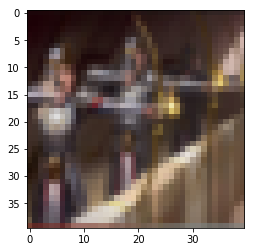

In [6]:
probe = 1
testpic = x_train_small_pre[probe,:,:,:]
print(testpic.shape)
plt.imshow(testpic.astype(np.uint8)) 
print(max(testpic[:,0,0]))

max: 0.36666666666666664
min: -0.4843137254901961
similarity: 0.7981162173202615
max: 221.0
min: 4.0


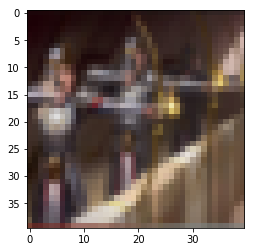

In [294]:
x_train_small = (x_train_small_pre-127.5)/255
#x_train_small = x_train_small_pre/255

testpic_sml = x_train_small[probe,:,:,:]
print("max:",np.amax(testpic_sml[:,:,2]))
print("min:",np.amin(testpic_sml[:,:,2]))

rdiff = np.ones([40*40])
gdiff = np.ones([40*40])
bdiff = np.ones([40*40])
rabsdiff= np.ones([4])
gabsdiff= np.ones([4])
babsdiff= np.ones([4])
for sample_in in range(4):
    intgr = 0
    for xax in range(40):
        for yax in range(40):
            rdiff[intgr] = x_train_small[0,xax,yax,0]-x_train_small[sample_in,xax,yax,0]
            gdiff[intgr] = x_train_small[0,xax,yax,1]-x_train_small[sample_in,xax,yax,1]
            bdiff[intgr] = x_train_small[0,xax,yax,2]-x_train_small[sample_in,xax,yax,2]
            intgr = intgr+1
    rabsdiff[sample_in] = 1-np.mean(abs(rdiff))
    gabsdiff[sample_in] = 1-np.mean(abs(gdiff))
    babsdiff[sample_in] = 1-np.mean(abs(bdiff))
      
print("similarity:",np.mean([rabsdiff,gabsdiff,babsdiff]))

testpic = ((x_train_small[probe,:,:,:]*255)+127.5)
#testpic = x_train_small[probe,:,:,:]*255
print("max:",np.amax(testpic[:,:,2]))
print("min:",np.amin(testpic[:,:,2]))
plt.imshow(testpic.astype(np.uint8)) 

In [182]:
class MinibatchDiscrimination(Layer):
 
    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=Kback.floatx(),
                                     shape=(None, input_dim))]

        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        # Set built to true.
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = Kback.reshape(Kback.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = Kback.expand_dims(activation, 3) - Kback.expand_dims(Kback.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = Kback.sum(Kback.abs(diffs), axis=2)
        minibatch_features = Kback.sum(Kback.exp(-abs_diffs), axis=2)
        return Kback.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [310]:
class DCGAN():
    def __init__(self,param):
        #with Kback.tf.device('/gpu:1'):
        self.img_rows =hrz
        self.img_cols = vrt
        self.channels = 3
        self.img_shape = (self.img_rows,self.img_cols,self.channels)
        self.latent_dim = 600
        
        learning_rate_gen =  0.0001 #3
        learning_rate_disc = 0.0001 #3
        optimizer_gen = Adam(lr = learning_rate_gen,beta_1 = 0.9, beta_2 = 0.999) 
        optimizer_disc = Adam(lr = learning_rate_disc,beta_1 = 0.9, beta_2 = 0.999) 
        #optimizer_gen = RMSprop(lr = learning_rate_gen) 
        #optimizer_disc = RMSprop(lr = learning_rate_disc) 

        self.discriminator = self.build_discriminator(int(param[0]))
        self.discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer_disc, metrics=['accuracy'])
        self.discriminator.summary
        self.generator = self.build_generator(int(param[1]))

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False
        for layer in self.discriminator.layers:
            layer.trainable = False
            
        valid = self.discriminator(img)

        self.combined = Model(z,valid)
        self.combined.compile(loss = 'binary_crossentropy', optimizer = optimizer_gen)
            
        
    #Build Discriminator
    def build_discriminator(self,depth):
        dropout = 0 #0.5
        input_shape = (hrz,vrt,3)

        discriminator_model = Sequential(name='discriminator')

        discriminator_model.add(Conv2D(depth*2,kernel_size =  5, strides=1,input_shape = input_shape, padding ='same'))
        #discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))

        discriminator_model.add(Conv2D(depth*2,kernel_size = 5,strides=2, padding ='same'))
        #discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))
        
#         discriminator_model.add(Conv2D(depth*2,kernel_size = 4,strides=1, padding ='same'))
#         discriminator_model.add(BatchNormalization(momentum=0.8))
#         discriminator_model.add(LeakyReLU(alpha = 0.2))
#         discriminator_model.add(Dropout(dropout))

        discriminator_model.add(Conv2D(depth*2,kernel_size = 4,strides=2, padding ='same'))
        #discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))
        
        discriminator_model.add(Conv2D(depth*2,kernel_size = 4,strides=2, padding ='same'))
        discriminator_model.add(BatchNormalization(momentum=0.8))
        discriminator_model.add(LeakyReLU(alpha = 0.2))
        discriminator_model.add(Dropout(dropout))
        
#         discriminator_model.add(Conv2D(depth*2,kernel_size = 3,strides=1, padding ='same'))
#         discriminator_model.add(BatchNormalization(momentum=0.8))
#         discriminator_model.add(LeakyReLU(alpha = 0.2))
#         discriminator_model.add(Dropout(dropout))

        discriminator_model.add(Flatten())
        discriminator_model.add(MinibatchDiscrimination(depth,3))
        
        #discriminator_model.add(Flatten())
        discriminator_model.add(Dense(1))
        discriminator_model.add(Activation('sigmoid'))
        return discriminator_model
    
    #Build generator
    def build_generator(self,depth):
        #depth = 32
        dropout  = 0 #0.5
        dim = 5
        
        generator_model = Sequential(name='generator')

        generator_model.add(Dense(depth*2*dim*dim,input_dim=self.latent_dim))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))
        generator_model.add(Reshape((dim,dim,depth*2)))
        
        generator_model.add(Conv2DTranspose(depth*2,kernel_size = 5, strides = 2, padding ='same'))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))

#         generator_model.add(Conv2D(depth*2,kernel_size = 5, strides = 1, padding ='same'))
#         generator_model.add(Dropout(dropout))
#         generator_model.add(BatchNormalization(momentum=0.8))
#         generator_model.add(LeakyReLU(alpha = 0.2))
        
        generator_model.add(Conv2DTranspose(depth*2,kernel_size = 5, strides = 2, padding ='same'))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))
        
#         generator_model.add(Conv2D(depth*2,kernel_size = 5, strides = 1, padding ='same'))
#         generator_model.add(Dropout(dropout))
#         generator_model.add(BatchNormalization(momentum=0.8))
#         generator_model.add(LeakyReLU(alpha = 0.2))
        
        generator_model.add(Conv2DTranspose(depth*2,kernel_size = 5, strides = 2, padding ='same'))
        generator_model.add(Dropout(dropout))
        generator_model.add(BatchNormalization(momentum=0.8))
        generator_model.add(LeakyReLU(alpha = 0.2))
        
        generator_model.add(Conv2D(self.channels,kernel_size = 5, strides = 1, padding ='same'))
        generator_model.add(Activation("tanh"))

        noise = Input(shape = (self.latent_dim,))
        img = generator_model(noise)
        return generator_model

In [312]:
#Training
epochs =5000
batch_size = 64
d_losses = np.ones([epochs,2])
g_losses = np.ones([epochs,2])

/usr/local/lib/python3.4/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0
0.9922094694749792
[1.         0.98971706 0.98865743 0.989957  ]
[1.         0.99006558 0.98928052 0.98988083]
[1.         0.98978054 0.98904333 0.99013135]
500
0.8925512977687738
[1.         0.85972114 0.85279954 0.83797643]
[1.         0.84921046 0.85103526 0.83639098]
[1.         0.87688694 0.88059129 0.86600354]
1000
0.9356584475094406
[1.         0.90759465 0.91084326 0.92231084]
[1.         0.90456027 0.90697966 0.92142053]
[1.         0.91482482 0.91559105 0.92377628]
1500
0.9806471511632034
[1.         0.9754326  0.97438309 0.97396803]
[1.         0.97301417 0.97188185 0.97317516]
[1.         0.97535441 0.97449759 0.97605891]
2000
0.9742572597228057
[1.         0.97009711 0.9626991  0.96188259]
[1.         0.97046606 0.96127333 0.96093416]
[1.         0.97197518 0.96637712 0.96538246]
2500
0.9759641511072848
[1.         0.96960525 0.97349996 0.96070862]
[1.         0.96890596 0.97314523 0.95979378]
[1.         0.97055255 0.97406437 0.96129408]
3000
0.9847679031230382
[1.     

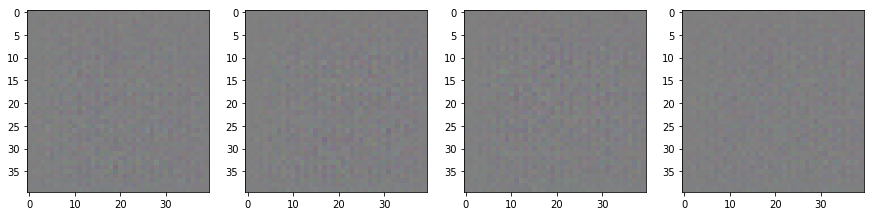

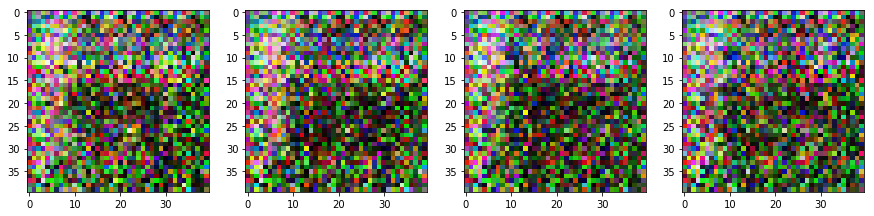

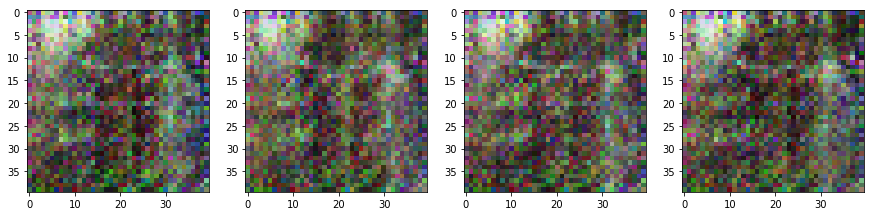

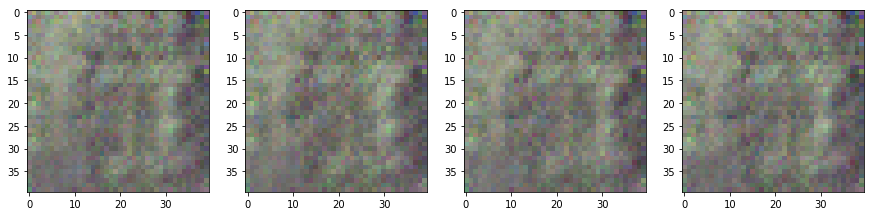

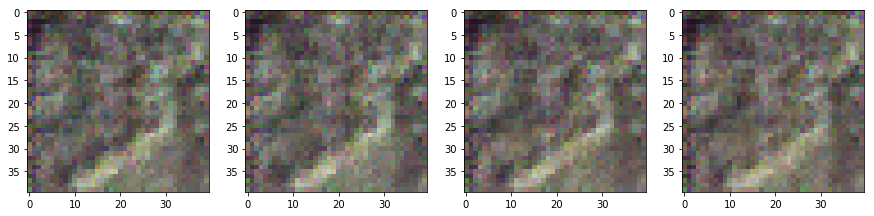

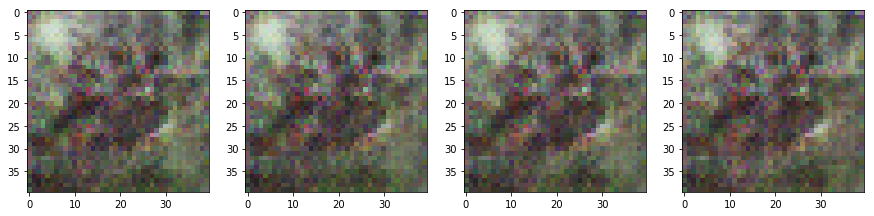

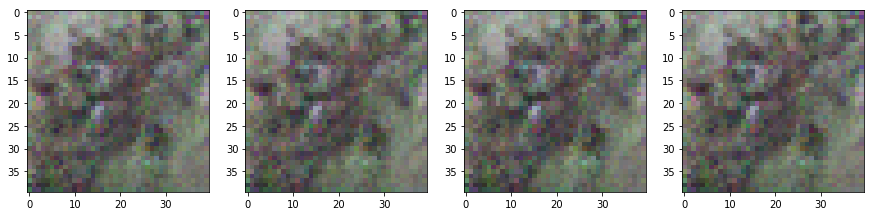

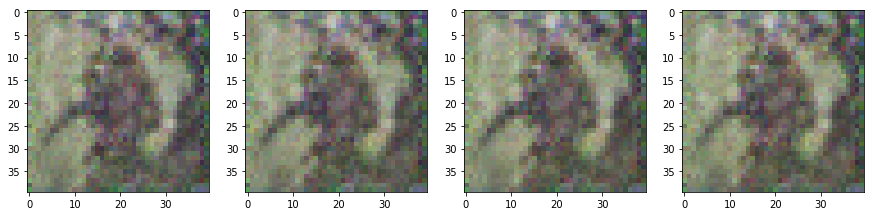

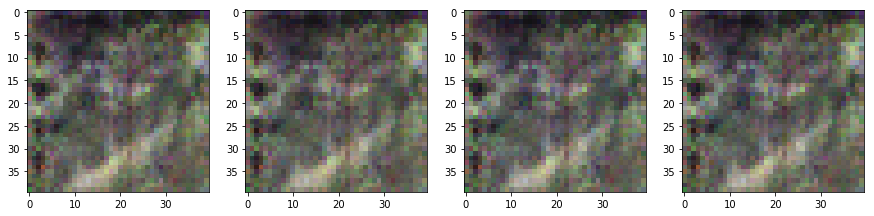

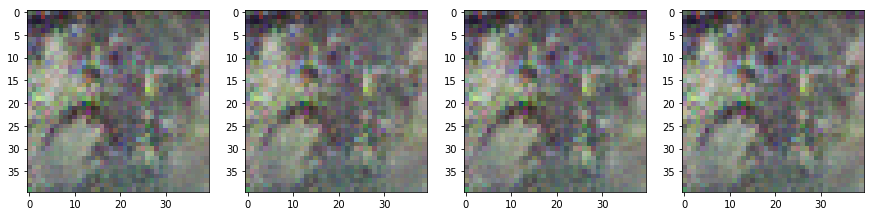

In [313]:
#tRAINING
loopits = 1
param1 = np.ones([2,loopits])
fake_samples =  np.ones([loopits,4,hrz,vrt,3])
scl = 32
handicap = 5
plotstuff = 1
flip = 1
param1[0][:] = [scl*1] #discriminator
param1[1][:] = [scl*1] #generator

samp_ind = -1
real_index = -1
fake_index = -1
d_loss_real = np.ones([loopits,epochs,2])
d_loss_fake = np.ones([loopits,epochs,2])
g_losses = np.ones([loopits,epochs,2])
similarity = np.ones([int(epochs/500)])
for looper in range(loopits):
    DCGAN_model = DCGAN(param1[:,looper])
    #DCGAN_model.generator.summary()
    #DCGAN_model.discriminator.summary()

    noise = np.random.normal(0,1.0, (int(batch_size),DCGAN_model.latent_dim))
    gen_imgs = DCGAN_model.generator.predict(noise)
    
    
    for epoch in range(epochs):
        #clear_output(wait=True)
        #print(looper)
        #print(epoch)
        idx = np.random.randint(0,x_train.shape[0],int(batch_size))
        imgs = x_train_small[idx]

        noise = np.random.normal(0,1.0, (int(batch_size),DCGAN_model.latent_dim))
        gen_imgs = DCGAN_model.generator.predict(noise)

        y_fake= np.random.uniform(0,0.1,batch_size)
        y_real = np.random.uniform(0.9,1,batch_size)
        y_true = np.ones([batch_size,1])           
        
        if flip:
            y_real= np.random.uniform(0,0.1,batch_size)
            y_fake = np.random.uniform(0.9,1,batch_size)
            y_true = np.zeros([batch_size,1])   
                  
    
        x_real = imgs
        x_fake = gen_imgs
                                        #Train on real data
        real_index = real_index+1
        x = x_real
        y = y_real
        #if np.random.randint(11) ==1:
        #    y = y_fake
        d_loss_real[looper,real_index,:] = DCGAN_model.discriminator.train_on_batch(x,y)        

                                        #Train on fake data
        fake_index = fake_index+1
        x = x_fake
        y = y_fake
        #if np.random.randint(11) ==1:
        #    y = y_real
        d_loss_fake[looper,fake_index,:] = DCGAN_model.discriminator.train_on_batch(x,y)

        noise = np.random.normal(0,1.0, (batch_size,DCGAN_model.latent_dim))
        
        if handicap < epoch:
            g_losses[looper,epoch,:] = DCGAN_model.combined.train_on_batch(noise,y_true)
        
        if plotstuff:
            if epoch%500==0: 
                samp_ind = samp_ind+1
                print(epoch)
                for sample in range(4):

                    noise = np.random.normal(0,1.0, size=[batch_size,DCGAN_model.latent_dim])
                    images_good_fake = DCGAN_model.generator.predict(noise)
                    fake_sample = (np.squeeze(images_good_fake[1,:,:,:]))  
                    fake_samples[looper,sample,:,:,:] = fake_sample
                fake_samples_scaled = (fake_samples+1)/2

                width = 15
                height = 15
                fig = plt.figure(figsize=(width,height))
                plt.subplot(1,4,1)
                plt.imshow(fake_samples_scaled[0,0,:,:])
                plt.subplot(1,4,2)
                plt.imshow(fake_samples_scaled[0,1,:,:])
                plt.subplot(1,4,3)
                plt.imshow(fake_samples_scaled[0,2,:,:])
                plt.subplot(1,4,4)
                plt.imshow(fake_samples_scaled[0,3,:,:])
                
                rdiff = np.ones([40*40])
                gdiff = np.ones([40*40])
                bdiff = np.ones([40*40])
                rabsdiff= np.ones([4])
                gabsdiff= np.ones([4])
                babsdiff= np.ones([4])
                for sample_in in range(4):
                    intgr = 0
                    for xax in range(40):
                        for yax in range(40):
                            rdiff[intgr] = fake_samples_scaled[0,0,xax,yax,0]-fake_samples_scaled[0,sample_in,xax,yax,0]
                            gdiff[intgr] = fake_samples_scaled[0,0,xax,yax,1]-fake_samples_scaled[0,sample_in,xax,yax,1]
                            bdiff[intgr] = fake_samples_scaled[0,0,xax,yax,2]-fake_samples_scaled[0,sample_in,xax,yax,2]
                            intgr = intgr+1
                    rabsdiff[sample_in] = 1-np.mean(abs(rdiff))
                    gabsdiff[sample_in] = 1-np.mean(abs(gdiff))
                    babsdiff[sample_in] = 1-np.mean(abs(bdiff))
                    
                similarity[samp_ind] = np.mean([rabsdiff,gabsdiff,babsdiff])
                print(np.mean([rabsdiff,gabsdiff,babsdiff]))
                print(rabsdiff)
                print(gabsdiff)
                print(babsdiff)

0.6489567419315312
[1.         0.52652429 0.49802139 0.51374174]
[1.         0.51326573 0.45563849 0.49723754]
[1.         0.60305311 0.58101596 0.59898265]


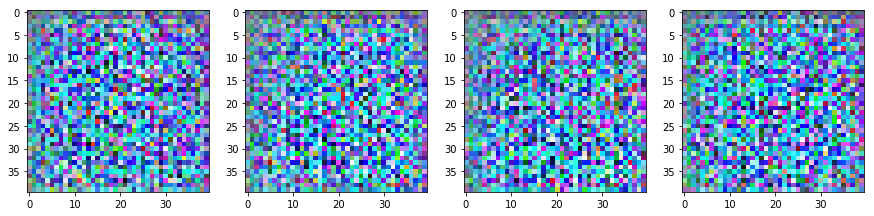

In [307]:
for sample in range(4):

    noise = np.random.normal(0,1.0, size=[batch_size,DCGAN_model.latent_dim])
    images_good_fake = DCGAN_model.generator.predict(noise)
    fake_sample = (np.squeeze(images_good_fake[1,:,:,:]))  
    fake_samples[looper,sample,:,:,:] = fake_sample


rdiff = np.ones([40*40])
gdiff = np.ones([40*40])
bdiff = np.ones([40*40])
rabsdiff= np.ones([4])
gabsdiff= np.ones([4])
babsdiff= np.ones([4])
for sample_in in range(4):
    intgr = 0
    for xax in range(40):
        for yax in range(40):
            rdiff[intgr] = fake_samples[0,0,xax,yax,0]-fake_samples[0,sample_in,xax,yax,0]
            gdiff[intgr] = fake_samples[0,0,xax,yax,1]-fake_samples[0,sample_in,xax,yax,1]
            bdiff[intgr] = fake_samples[0,0,xax,yax,2]-fake_samples[0,sample_in,xax,yax,2]
            intgr = intgr+1
    rabsdiff[sample_in] = 1-np.mean(abs(rdiff))
    gabsdiff[sample_in] = 1-np.mean(abs(gdiff))
    babsdiff[sample_in] = 1-np.mean(abs(bdiff))

width = 15
height = 15
plt.figure(figsize=(width,height))
scale = 1;
plotcounter = 1;

noise = np.random.uniform(0,1.0, size=[batch_size,DCGAN_model.latent_dim])

fake_samples_scaled = (fake_samples+1)/2

for looper in range(loopits):
 
    plt.subplot(loopits,4,plotcounter)
    plt.imshow(fake_samples_scaled[looper,0,:,:])
    plt.subplot(loopits,4,plotcounter+1)
    plt.imshow(fake_samples_scaled[looper,1,:,:])
    plt.subplot(loopits,4,plotcounter+2)
    plt.imshow(fake_samples_scaled[looper,2,:,:])
    plt.subplot(loopits,4,plotcounter+3)
    plt.imshow(fake_samples_scaled[looper,3,:,:])
    plotcounter = plotcounter+4
print(np.mean([rabsdiff,gabsdiff,babsdiff]))  
print(rabsdiff)
print(gabsdiff)
print(babsdiff)

In [308]:
d_loss_real_plot = np.swapaxes(d_loss_real,0,1)
d_loss_fake_plot = np.swapaxes(d_loss_fake,0,1)
g_losses_plot = np.swapaxes(g_losses,0,1)

(10000,)


/usr/local/lib/python3.4/dist-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python3.4/dist-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


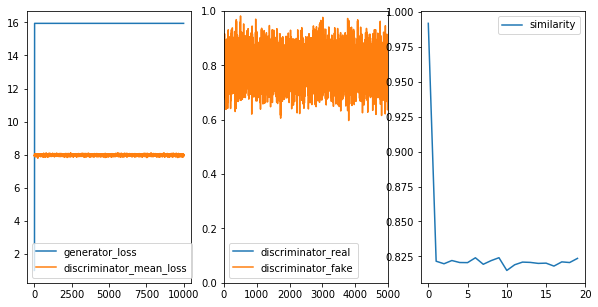

In [309]:
d_mean_loss_plot = (d_loss_real_plot[:,0,0]+d_loss_fake_plot[:,0,0])/2
d_mean_loss_plot = d_mean_loss_plot[1:int(epochs/2)]
width = 10
height = 5
plt.figure(figsize=(width,height))
plt.subplot(1,3,1)
plt.plot(g_losses_plot[:,0,0],label='generator_loss')
d_mean_inter = scp.signal.resample(d_mean_loss_plot,epochs)
print(d_mean_inter.shape)
plt.plot(d_mean_inter,label='discriminator_mean_loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(d_loss_real_plot[:,0,0] ,label='discriminator_real')
plt.plot(d_loss_fake_plot[:,0,0] ,label='discriminator_fake')
plt.xlim((0,epoch/2))
plt.ylim((0,1))
plt.legend()
plt.subplot(1,3,3)
plt.plot(similarity ,label='similarity')
plt.legend()